In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import Machine, generate_objects, BunchTracker, track, compare_traces, compare_projections

from PyHEADTAIL_feedback.feedback import IdealBunchFeedback,IdealSliceFeedback,OneboxFeedback
from PyHEADTAIL_feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL_feedback.processors.linear_transform import Averager
from PyHEADTAIL_feedback.processors.misc import Bypass

np.random.seed(0)

PyHEADTAIL v(no git available to determine version)




In [2]:
""" 
    This example shows how to use ideal feedback systems in PyHEADTAIL simulations. In order to avoid writing
    unnecessary code here, the used bunch, slicer and transfer maps are created by using functions and classes
    written to file test_tools.py in this folder.

    @author Jani Komppula
    @date 26/09/2016
    @copyright CERN
"""

u' \n    This example shows how to use ideal feedback systems in PyHEADTAIL simulations. In order to avoid writing\n    unnecessary code here, the used bunch, slicer and transfer maps are created by using functions and classes\n    written to file test_tools.py in this folder.\n\n    @author Jani Komppula\n    @date 26/09/2016\n    @copyright CERN\n'

In [3]:
# Basic parameters for the simulation
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 3 

n_turns = 150

# Longitudinal motion of the bunch has not been taken into account in this example.
machine = Machine(Q_s = 0.00000001)
# If you want to include the longitudinal motion, please uncomment the following line
# machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles,n_segments, 
                                                             n_slices,n_sigma_z)

In [4]:
# This creates an artificially kicked bunch, which will be damped with different feedback systems

slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

# Random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))
# A bunch kick
# kick_x = 0.003*np.ones(n_slices)
# kick_y = 0.003*np.ones(n_slices)

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

In [5]:
# In the used code, the parameter 'gain' is determined as a fraction of the input signal which is corrected, 
# if the signal passes through the signal processors without modifications.

# There are two ways to set a gain value. If only one value is given, same value is used for both
# in the horizontal and the vertical planes. If two values are given, separed values (x,y) are used for the 
# horizontal and the vertical planes

feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

In [6]:
# The simplest possible feedback is a bunch feedback. It takes the mean_xp and mean_yp values of the bunch 
# and correct those values by a fraction of gain.

# The bunch is created by copying the bunch created in earlier
bunch_IdealBunchFB = copy.deepcopy(bunch_ref)

# A tracker object from test_tools.py is used for recording the values of the bunch during the bunch traking
tracker_IdealBunchFB = BunchTracker(bunch_IdealBunchFB)

# A PyHEADTAIL map element for the total map is created by creating IdealBunchFeedback() object. The only
# input parameter is the gain
feedback_map = IdealBunchFeedback(feedback_gain)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]

# The actual simulation is done by calling track method from test_tools.py
track(n_turns, bunch_IdealBunchFB,total_map_FB,tracker_IdealBunchFB)

In [7]:
# The most idealistic feedback is a slice feedback. It takes the mean_xp and mean_yp values from each slice 
# and correct them by a fraction of gain.

bunch_IdealSliceFB = copy.deepcopy(bunch_ref)
tracker_IdealSliceFB = BunchTracker(bunch_IdealSliceFB)
slicer_IdealSliceFB = copy.deepcopy(slicer_ref)

# A PyHEADTAIL map element for the total map is created by creating IdealSliceFeedback() object. The only
# input parameter is the gain and a slicer for the bunch
feedback_map = IdealSliceFeedback(feedback_gain,slicer_IdealSliceFB)
total_map_FB = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_IdealSliceFB,total_map_FB,tracker_IdealSliceFB)

In [8]:
# The examples above utilize separately programmed classes for ideal feedbacks. The actual feedback module
# utilizes objects namely signal processors for modifying signal between pickup and kicker. In order to learn
# this concept, we build the above introduced ideal feedbacks by using OneboxFeedback object.
#
# The easiest feedback systemn to implement is the ideal slice feedback, which has been presented at first.

bunch_OneBox_slice = copy.deepcopy(bunch_ref)
tracker_OneBox_slice = BunchTracker(bunch_OneBox_slice)
slicer_OneBox_slice = copy.deepcopy(slicer_ref)


# By the defaul, OneboxFeedback takes mean xp/yp values from the slices and gives that as an input signal for 
# signal processors. The signal goes throught all the signal processors, which are given as lists for
# horizontal and vertical planes. The final corrections for mean xp/yp values of the slices are the signals 
# from the signal processors, which are multiplied by a gain value. The definition for the gain value is that it 
# it is a fraction of the mean xp/yp values of the slices corrected if the signal is not modified in the 
# signal processors.
#
# In the ideal slice feedback, signals are not modified in the signal processors. Thus, a processor Bypass() 
# is used in both vertical and horizontal planes, which bypasses the signals without any modifications.

processors_slice_x = [Bypass()]
processors_slice_y = [Bypass()]

# A PyHEADTAIL map element is created by calling OneboxFeedback(...) object. OneboxFeedback requires a gain
# value, a PyHEADTAIL slicer object and lists of signal processors used in horizontal and vertical plane
# as input arguments
feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox_slice,processors_slice_x,processors_slice_y)
total_map_OneBox_slice = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_slice,total_map_OneBox_slice,tracker_OneBox_slice)

In [9]:
bunch_OneBox_bunch = copy.deepcopy(bunch_ref)
tracker_OneBox_bunch = BunchTracker(bunch_OneBox_bunch)
slicer_OneBox_bunch = copy.deepcopy(slicer_ref)

# The ideal bunch feedback makes corrections to mean xp/yp values of the bunch. In order to implement this 
# the input signal (mean xp/yp values of the slices) must be modified to the mean xp/yp value of the bunch 
# the with signal processors. Because there are different number particles in each slice this can not be done
# by simply averaging the values from the slices, but the signal must be weighted by 
# a number of macro particles per slice at first. The weighting can be done by using ChargeWeighter(...). 
# By the default, the maximum weight in ChargeWeighter is normalized to be one, but, in this case, an average 
# weight must be 1, so an input parameter for the normalization is used. 

processors_bunch_x = [
    ChargeWeighter(normalization = 'average'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'average'),
    Averager()
]

feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox_bunch,processors_bunch_x,processors_bunch_y)
total_map_OneBox_bunch = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_bunch,total_map_OneBox_bunch,tracker_OneBox_bunch)

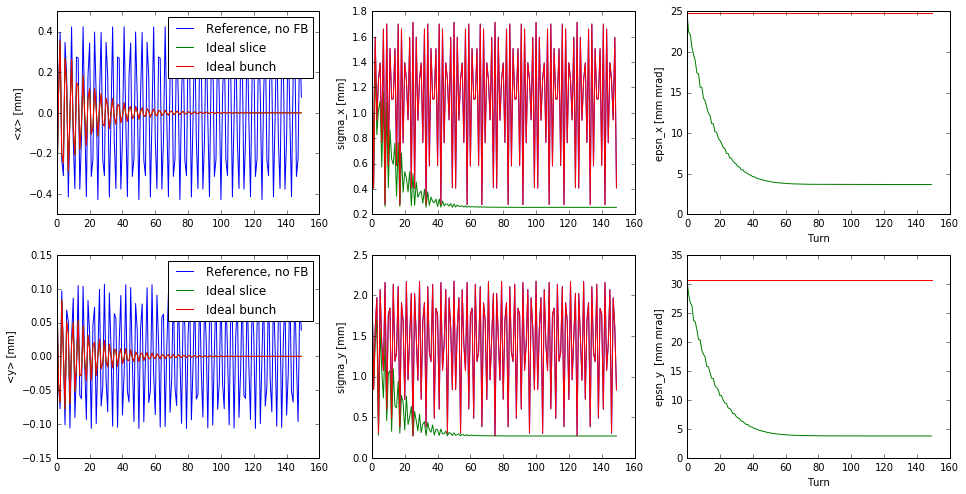

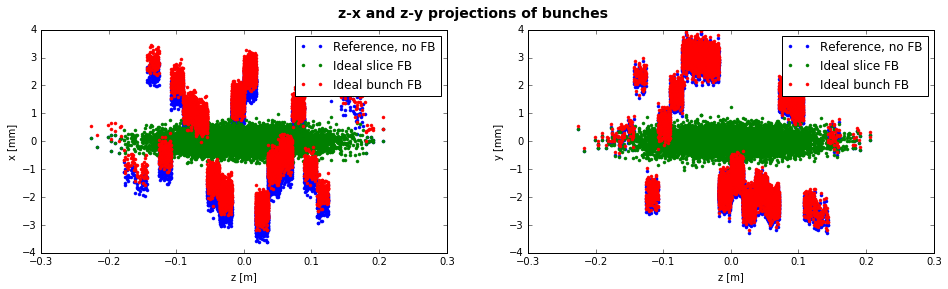

In [10]:
# The traces from the ideal slice and the ideal bunch feedbacks are plotted as well as 
# the particle projections of the bunches after the simulations

compare_traces([tracker_ref,tracker_IdealSliceFB,tracker_IdealBunchFB],
               ['Reference, no FB', 'Ideal slice', 'Ideal bunch'])
compare_projections([bunch_init, bunch_IdealSliceFB, bunch_IdealBunchFB], 
                    ['Reference, no FB', 'Ideal slice FB', 'Ideal bunch FB'])

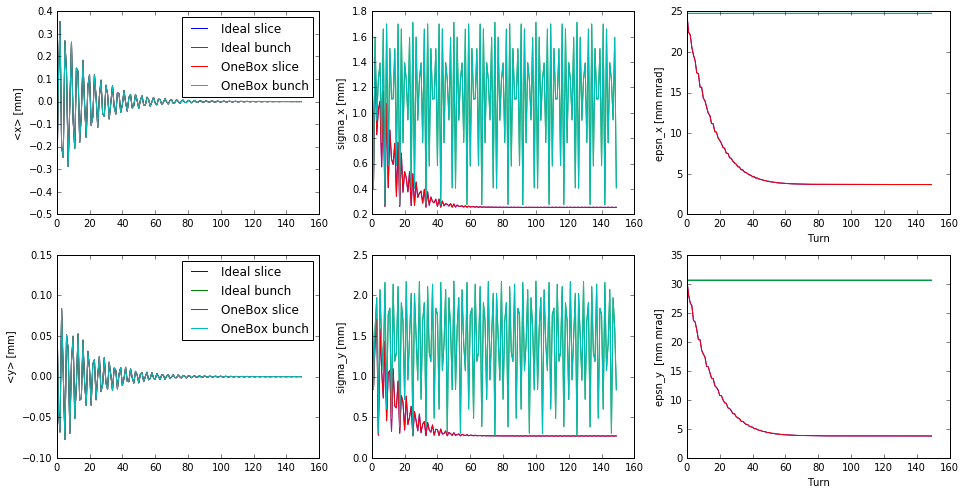

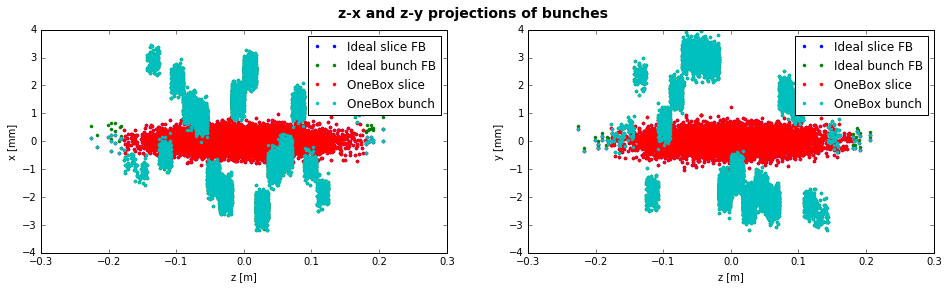

In [11]:
# In here, the traces and particle projections from the ideal slice and the idal bunch feedbacks are compared 
# to those implemented with OneboxFeedback

compare_traces([tracker_IdealSliceFB,tracker_IdealBunchFB, tracker_OneBox_slice, tracker_OneBox_bunch],
               ['Ideal slice', 'Ideal bunch','OneBox slice', 'OneBox bunch'])
compare_projections([bunch_IdealSliceFB, bunch_IdealBunchFB,bunch_OneBox_slice,bunch_OneBox_bunch], 
                    ['Ideal slice FB', 'Ideal bunch FB','OneBox slice', 'OneBox bunch'])